In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import polars as pl


## Loading the dataset

In [6]:
df = pd.read_csv("Trips_2018.csv")

#count cpu cores
cores = os.cpu_count()
print(cores)

16


In [7]:
df.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


In [8]:
print(df.dtypes)

Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object


## Preprocessing

In [9]:
#df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')
#df['stoptime'] = pd.to_datetime(df['stoptime'], errors='coerce')

df['starttime']=pd.to_datetime(df['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
df['stoptime']=pd.to_datetime(df['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")

In [10]:
print(df.dtypes)

Unnamed: 0                          int64
tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                  float64
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_latitude              float64
end_station_longitude             float64
bikeid                              int64
usertype                           object
birth_year                          int64
gender                              int64
dtype: object


In [ ]:
# Encode the 'usertype' column from string to int
label_encoder = LabelEncoder()
df['usertype'] = label_encoder.fit_transform(df['usertype'])


df = df.dropna(subset=['start_station_id', 'end_station_id'])
df['start_station_id'] = df['start_station_id'].astype(int)
df['end_station_id'] = df['end_station_id'].astype(int)

In [12]:
print(df['gender'].unique())
print(df['usertype'].unique())

[1 0 2]
[1 0]


In [13]:
# Drop any duplicate row
df2 = df.drop_duplicates()

In [15]:
print('df2:',df2.shape[0],'df:',df.shape[0])

df2: 17545842 df: 17545842


In [ ]:

##!setx LOKY_Min_CPU_COUNT 6
#
#distortions = []
#K = range(1, 25) 
#
#for k in K:
#    kmeanModel = KMeans(n_clusters=k)
#    kmeanModel.fit(df[['start_station_latitude', 'start_station_longitude']])
#    distortions.append(kmeanModel.inertia_)
#
## Plotting the elbow curve
#plt.figure(figsize=(16, 8))
#plt.plot(K, distortions, 'bx-')
#plt.xlabel('k')
#plt.ylabel('Distortion')
#plt.title('The Elbow Method showing the optimal k')
#plt.show()


In [ ]:
#from yellowbrick.cluster import KElbowVisualizer
#from sklearn.cluster import KMeans
#
## Generate synthetic dataset with 8 random clusters
#X =df[['start_station_latitude', 'start_station_longitude']]
#
## Instantiate the clustering model and visualizer
#model = KMeans()
#visualizer = KElbowVisualizer(model, k=(1,25))
#
#visualizer.fit(X)        # Fit the data to the visualizer
#visualizer.show()        # Finalize and render the figure

c:\Users\spbsp\anaconda3\envs\ddpm\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


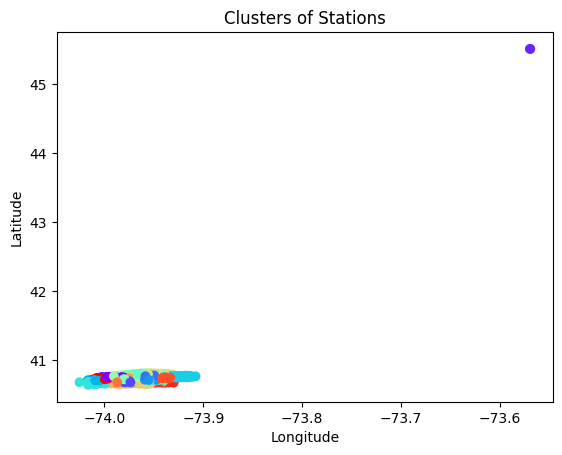

In [26]:
## Create a dataframe with the start station id and the coordinates
stations = df2[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates()

## Apply KMeans algorithm for 21 clusters
kmeans = KMeans(n_clusters=21, random_state=0).fit(stations[['start_station_latitude', 'start_station_longitude']])
stations['cluster'] = kmeans.labels_

## Plot the clusters
plt.scatter(stations['start_station_longitude'], stations['start_station_latitude'], c=stations['cluster'], cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Stations')
plt.show()

In [27]:
stations.shape

(819, 4)

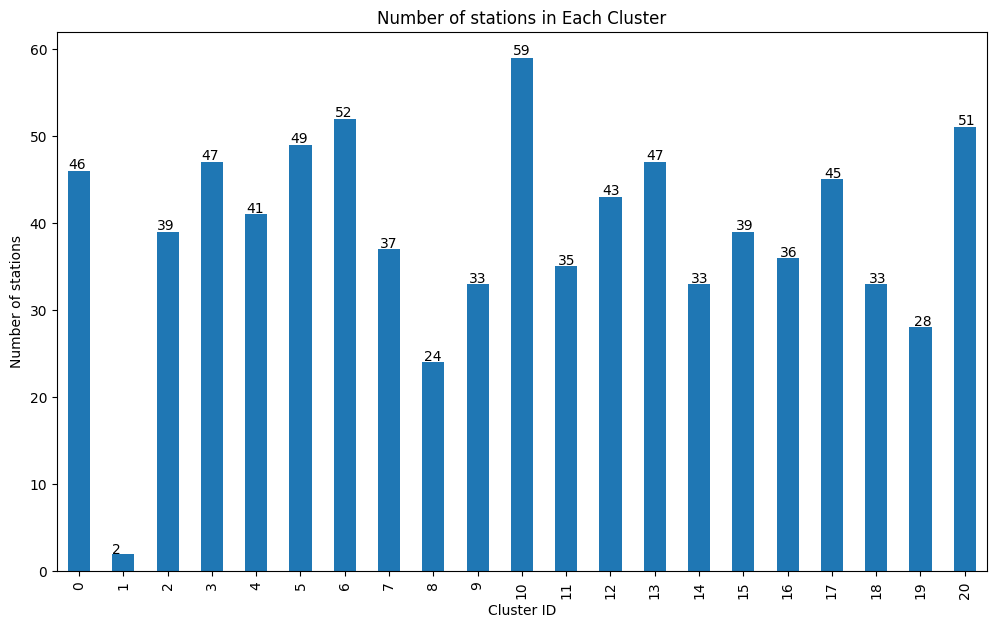

In [28]:
## Plot the stations in each cluster
cluster_counts = stations.groupby('cluster').size()

ax = cluster_counts.plot(kind='bar', figsize=(12,7))
plt.xlabel('Cluster ID')
plt.ylabel('Number of stations')
plt.title('Number of stations in Each Cluster')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()


In [29]:
cluster_1_stations = stations[stations['cluster'] == 1]
print(cluster_1_stations)

        start_station_id  start_station_latitude  start_station_longitude  \
676612              3488               45.506364               -73.569463   
714485              3650               45.506264               -73.568906   

        cluster  
676612        1  
714485        1  


These 2 stations are located in Montreal, Canada. Therefore, they will be discarded.

In [30]:
## Drop the rows with cluster 1
stations = stations[stations['cluster'] != 1]

In [31]:
stations.head()

,start_station_id,start_station_latitude,start_station_longitude,cluster
0,72,40.767272,-73.993929,11
1324,79,40.719116,-74.006667,5
2430,82,40.711174,-74.000165,5
2866,83,40.683826,-73.976323,2
3551,119,40.696089,-73.978034,2


In [32]:
## Check the unique clusters
stations['cluster'].unique()

array([11,  5,  2, 20, 17, 10, 12, 16,  0, 14, 19,  4,  8, 18,  3,  9,  7,
       15, 13,  6])

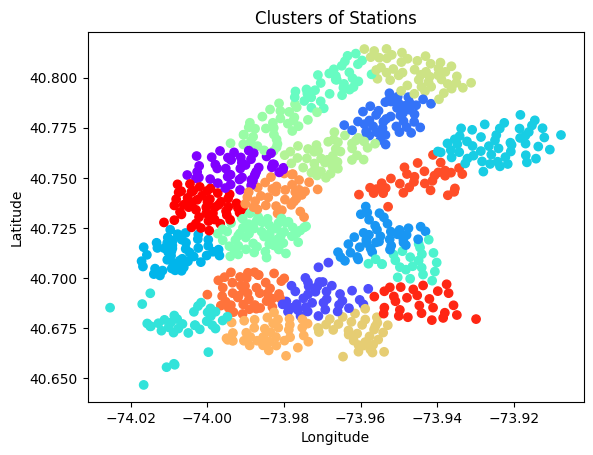

In [33]:
plt.scatter(stations['start_station_longitude'], stations['start_station_latitude'], c=stations['cluster'], cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Stations')
plt.show()

In [34]:
merged_df = df.merge(stations[['start_station_id', 'cluster']], on='start_station_id', how='left')

merged_df.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,cluster
0,0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,1,1992,1,11.0
1,1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,1,1969,1,11.0
2,2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,1,1956,1,11.0
3,3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,1,1974,1,11.0
4,4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,1,1992,1,11.0


Text(0.5, 1.0, 'Stations Locations')

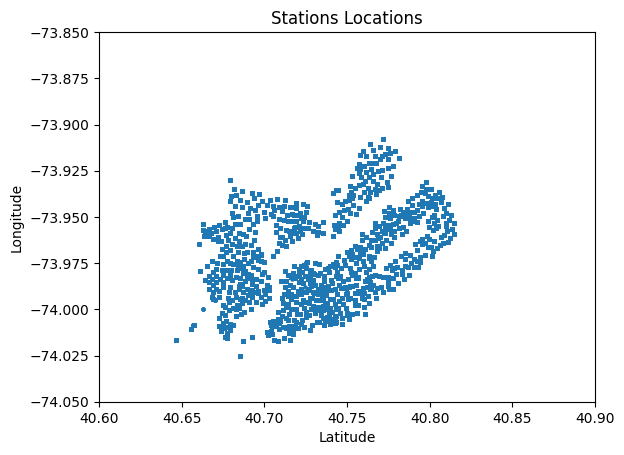

In [35]:
plt.scatter(merged_df['start_station_latitude'], merged_df['start_station_longitude'], s=5)
plt.xlim([40.6, 40.9])
plt.ylim([-74.05, -73.85])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title("Stations Locations")

C:\Users\spbsp\AppData\Local\Temp\ipykernel_23976\2249846221.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(merged_df['start_station_latitude'], merged_df['start_station_longitude'], cmap='rainbow', s=5)


Text(0.5, 1.0, 'Stations Locations')

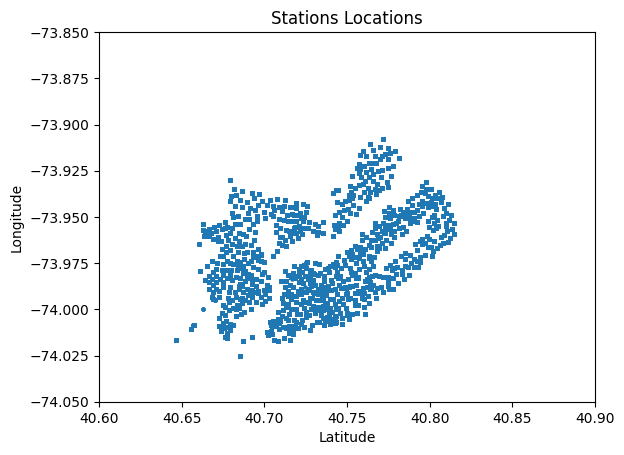

In [39]:
# Do the same plot but with colors in correspondance to the clusters
plt.scatter(merged_df['start_station_latitude'], merged_df['start_station_longitude'], c=merged_df['cluster'], cmap='rainbow', s=5) 
plt.xlim([40.6, 40.9])
plt.ylim([-74.05, -73.85])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title("Stations Locations")

In [40]:
df2=merged_df
# find min, max, median, mean, std of trip duration
print(df2['tripduration'].describe())

count    1.759132e+07
mean     9.887381e+02
std      1.887641e+04
min      6.100000e+01
25%      3.590000e+02
50%      6.050000e+02
75%      1.061000e+03
max      1.951005e+07
Name: tripduration, dtype: float64


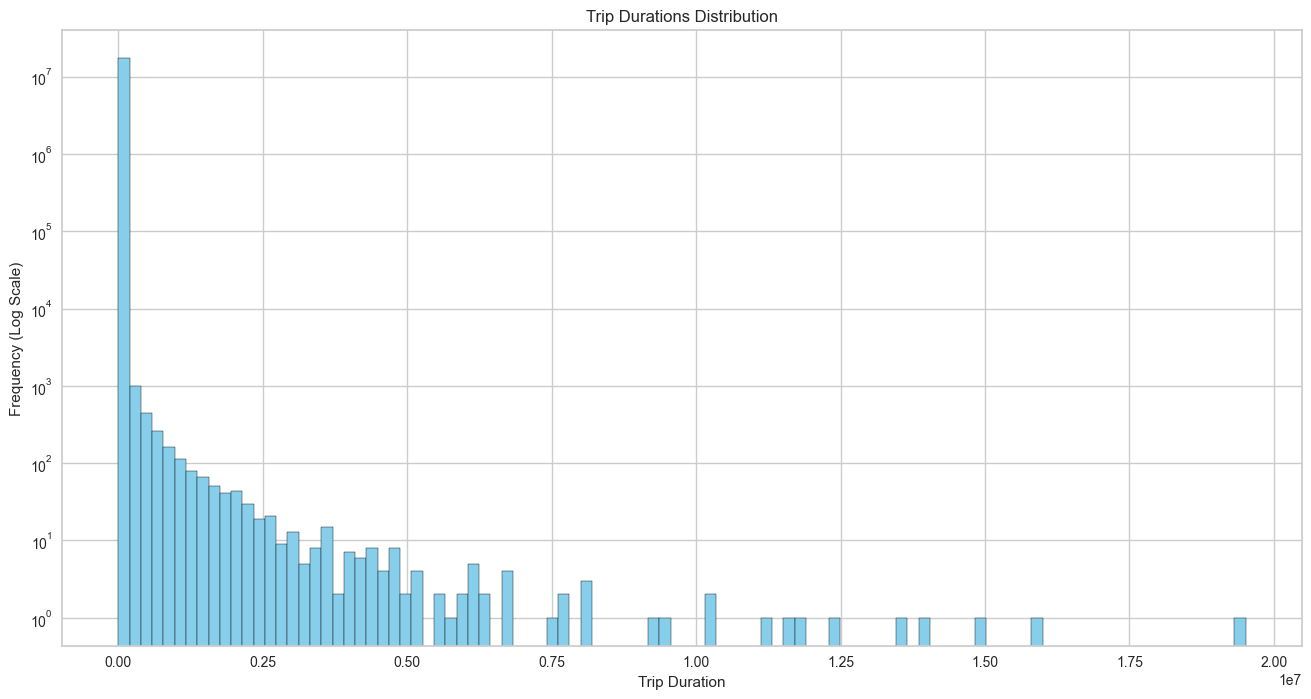

In [61]:
## Plot the distribution of trip durations
trip_durations = df2['tripduration']

plt.figure(figsize=(16, 8))
plt.hist(trip_durations, bins=100, color='skyblue', edgecolor='black')
plt.yscale('log')
plt.title('Trip Durations Distribution')
plt.xlabel('Trip Duration')
plt.ylabel('Frequency (Log Scale)')
plt.grid(True)
plt.show()



In [92]:
#Filtering the data at the 1st percentile will include those trips with durations longer than 99% of the dataset. 
#Filtering at the 99th percentile will include those trips with durations shorter than 99% of the dataset.

# Calculate the 0.1st and 999th percentiles
percentile_1 = df2['tripduration'].quantile(0.001)
percentile_99 = df2['tripduration'].quantile(0.999999)
# i want to print the tripdurations of those who are in the 1st and 99th percentile
print('trip_durations :', percentile_1, percentile_99)

# Filter data based on percentiles
points_within_1_percentile = df2[df2['tripduration'] <= percentile_1]
points_within_99_percentile = df2[df2['tripduration'] >= percentile_99]

print(f"Number of points in the 1st percentile: {len(points_within_1_percentile)}")
print(f"Number of points in the 99th percentile: {len(points_within_99_percentile)}")


trip_durations : 66.0 7579847.566582724
Number of points in the 1st percentile: 18486
Number of points in the 99th percentile: 18


In [94]:
# find min and 0.1, 0.5, 0.1 quantile of trip duration along with thenumber of points for each one of them
print(df2['tripduration'].quantile([.1, .05, .02, .01, .001, .0001, .00001]))
# find the 90,95,98,99 percentile of trip duration
print(df2['tripduration'].quantile([.90,.95,.98,.99,.999,.9999,.99999]))

0.10000    226.0
0.05000    171.0
0.02000    124.0
0.01000    100.0
0.00100     66.0
0.00010     61.0
0.00001     61.0
Name: tripduration, dtype: float64
0.90000    1.668000e+03
0.95000    2.097000e+03
0.98000    2.722000e+03
0.99000    3.718000e+03
0.99900    2.000997e+04
0.99990    3.433650e+05
0.99999    2.252608e+06
Name: tripduration, dtype: float64


In [ ]:
# Assuming 'df' is your DataFrame and 'tripduration' is the column you want to filter
# Calculate the 1st and 99th percentiles
lower_percentile = df2['tripduration'].quantile(0.01)
upper_percentile = df2['tripduration'].quantile(0.99)

# Filter the DataFrame based on the percentiles
#filtered_df = df[(df['tripduration'] >= lower_percentile) & (df['tripduration'] <= upper_percentile)]


In [95]:
df.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,cluster
0,0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1992,1,5.0
1,1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1969,1,5.0
2,2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1956,1,5.0
3,3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1974,1,5.0
4,4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1992,1,5.0


In [50]:
## Make a list of 20 lists that will include the id's of the stations in each cluster
cluster_stations = []
for i in range(21):
    cluster_stations.append(stations[stations['cluster'] == i]['start_station_id'].tolist())

# make a list of 20 lists that will include the id's of the stations in each cluster
print(len(cluster_stations))
print(cluster_stations[11])

21
[72, 422, 423, 447, 449, 457, 468, 469, 480, 499, 513, 530, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3169, 3171, 3172, 3173, 3175, 3176, 3177, 3178, 3226, 3356, 3360, 3697, 530]


In [45]:
stations.head()

,start_station_id,start_station_latitude,start_station_longitude,cluster
0,72,40.767272,-73.993929,11
1324,79,40.719116,-74.006667,5
2430,82,40.711174,-74.000165,5
2866,83,40.683826,-73.976323,2
3551,119,40.696089,-73.978034,2


In [47]:
## Add 'clusterend' column to the dataframe

# Map 'end_station_id' to 'cluster' using the cluster_stations information
end_station_to_cluster = {station: cluster for cluster, stations in enumerate(cluster_stations) for station in stations}

# Apply the mapping to 'end_station_id' to create the 'clusterend' column
df2['clusterend'] = df2['end_station_id'].map(end_station_to_cluster)


In [48]:
df2.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,cluster,clusterend
0,0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,1,1992,1,11.0,0.0
1,1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,1,1969,1,11.0,0.0
2,2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,1,1956,1,11.0,0.0
3,3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,1,1974,1,11.0,11.0
4,4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,1,1992,1,11.0,11.0


In [62]:
df2.shape

(17591315, 16)

## Create a new dataframe for the cluster with the highest demand


In [57]:
# Calculate total demand (arrivals) for each cluster
cluster_demand = df2.groupby('cluster').size()

# Find the cluster with the highest demand
cluster_highest_demand = cluster_demand.idxmax()

# Create a new DataFrame with data points only from the cluster with the highest demand
df_onecluster = df2[df2['cluster'] == cluster_highest_demand]
#This code groups the data by the 'cluster' column and counts the occurrences of each 

In [58]:
df_onecluster.head() 

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,cluster,clusterend
4183,4183,1176,2018-01-01 01:11:58.481,2018-01-01 01:31:34.729,127,40.731724,-74.006744,382,40.734927,-73.992005,25514,1,1979,2,20.0,20.0
4184,4184,1824,2018-01-01 01:12:26.474,2018-01-01 01:42:50.474,127,40.731724,-74.006744,530,40.771522,-73.990541,30370,1,1969,1,20.0,11.0
4185,4185,613,2018-01-01 09:55:37.097,2018-01-01 10:05:50.697,127,40.731724,-74.006744,3255,40.750585,-73.994685,25036,1,1966,1,20.0,0.0
4186,4186,463,2018-01-01 10:27:30.491,2018-01-01 10:35:13.638,127,40.731724,-74.006744,229,40.727434,-73.993790,33019,1,1992,1,20.0,10.0
4187,4187,454,2018-01-01 10:27:52.262,2018-01-01 10:35:26.884,127,40.731724,-74.006744,229,40.727434,-73.993790,27221,1,1991,2,20.0,10.0


In [59]:
df_onecluster['cluster'].unique()

array([20.])

In [61]:
#print the total rows of data_from_highest_demand_cluster
print(df_onecluster.shape[0])

2335291


In [63]:
print(2335291/17591315)

0.13275249746821088
